In [39]:
from datasetsforecast.m4 import M4

from statsmodels.tsa.stattools import acf, pacf

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import logging

In [40]:
sns.set_theme(style="whitegrid")
logging.getLogger('matplotlib').setLevel(logging.WARNING)

In [41]:
df_all, *_ = M4.load('./data', 'Hourly')
df_all['ds'] = df_all['ds'].astype(int)

# Just pick out the first few datasets to work with.
n_series = 20
uids = df_all['unique_id'].unique()[:n_series]
df = df_all.query('unique_id in @uids').copy()

df.head()

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


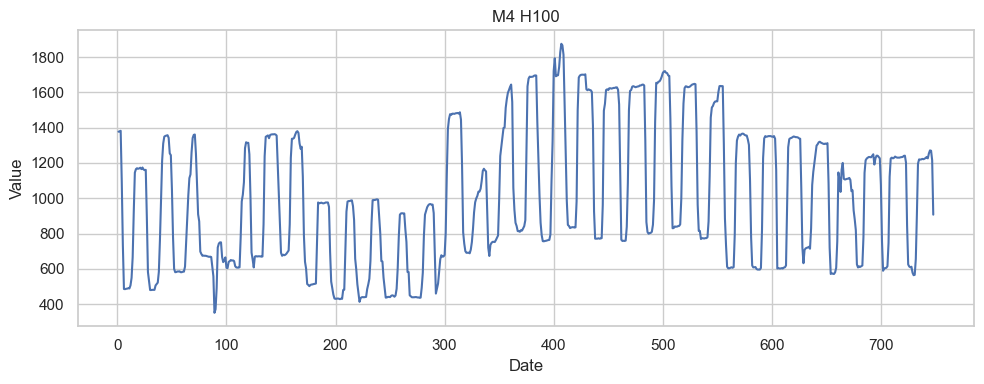

In [42]:
ds = df.query("unique_id == 'H100'").copy()

fig, axs = plt.subplots(1, 1, figsize=(10, 4), sharex=True)

sns.lineplot(ax=axs, data=ds, x='ds', y='y')
axs.set_title('M4 H100')
axs.set_ylabel('Value')

axs.set_xlabel('Date')

plt.tight_layout()
plt.show()

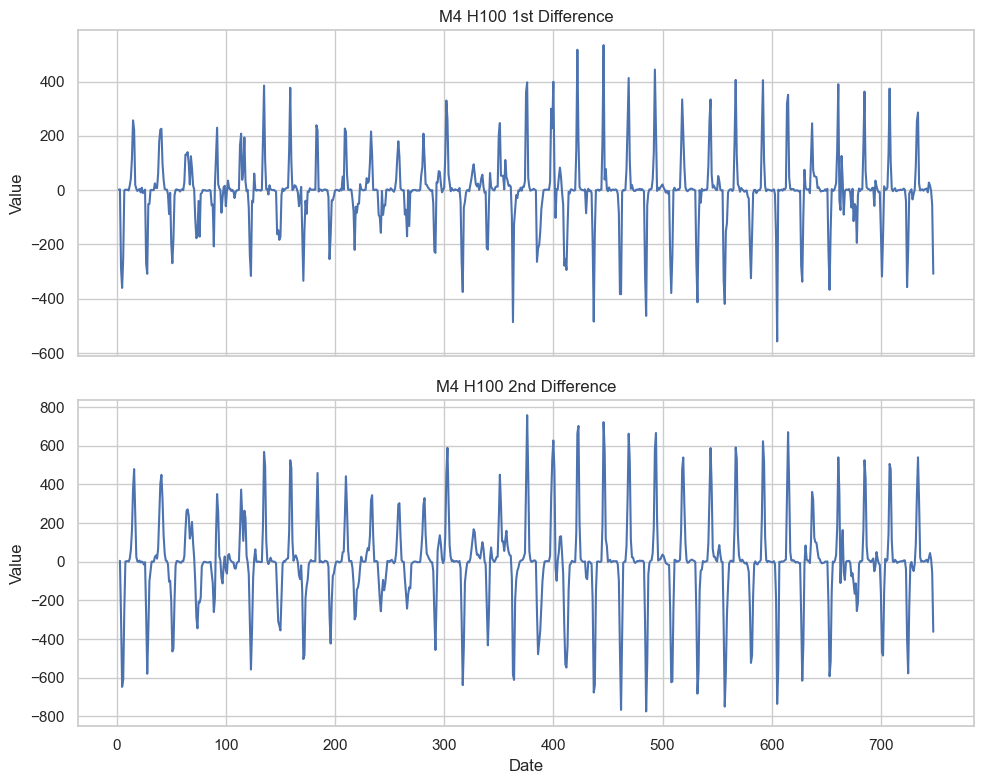

In [43]:
ds['y_diff_1'] = ds['y'].diff(periods=1)
ds['y_diff_2'] = ds['y'].diff(periods=2)

fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

sns.lineplot(ax=axs[0], data=ds, x='ds', y='y_diff_1')
axs[0].set_title('M4 H100 1st Difference')
axs[0].set_ylabel('Value')

sns.lineplot(ax=axs[1], data=ds, x='ds', y='y_diff_2')

axs[1].set_title('M4 H100 2nd Difference')
axs[1].set_ylabel('Value')

axs[1].set_xlabel('Date')

plt.tight_layout()
plt.show()

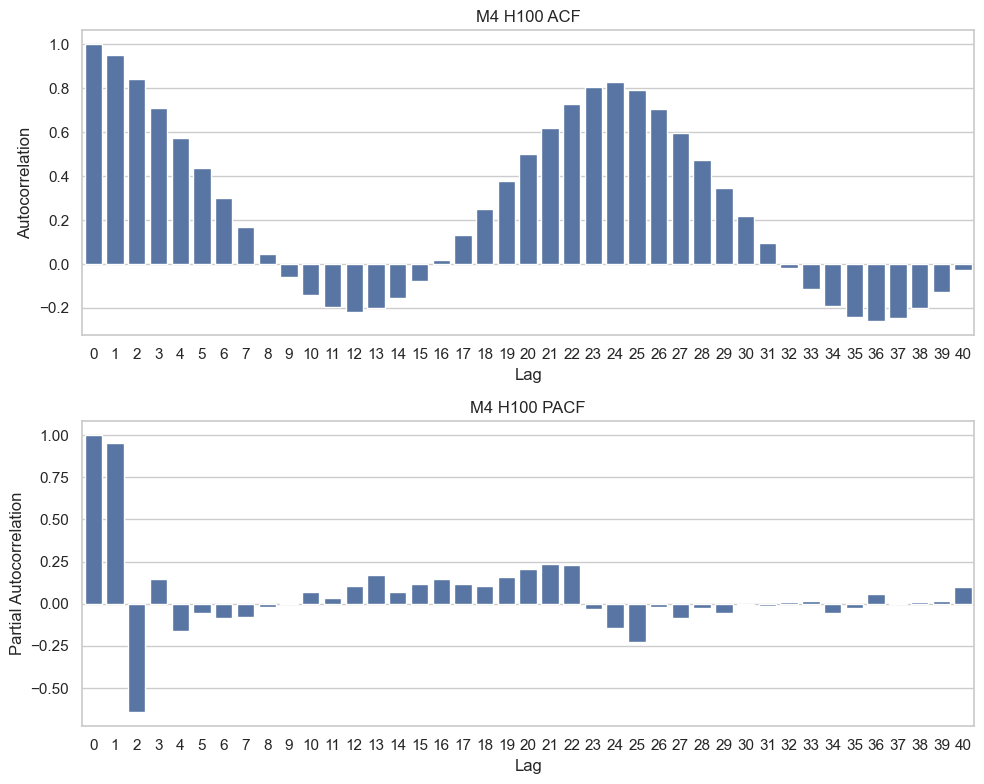

In [44]:
total_lags = 40

acf_values = acf(ds['y'], nlags=total_lags)
pacf_values = pacf(ds['y'], nlags=total_lags)

lags = np.arange(total_lags + 1)

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

sns.barplot(ax=axs[0], x=lags, y=acf_values)
axs[0].set_title('M4 H100 ACF')
axs[0].set_ylabel('Autocorrelation')
axs[0].set_xlabel('Lag')

sns.barplot(ax=axs[1], x=lags, y=pacf_values)
axs[1].set_title('M4 H100 PACF')
axs[1].set_ylabel('Partial Autocorrelation')
axs[1].set_xlabel('Lag')

plt.tight_layout()
plt.show()

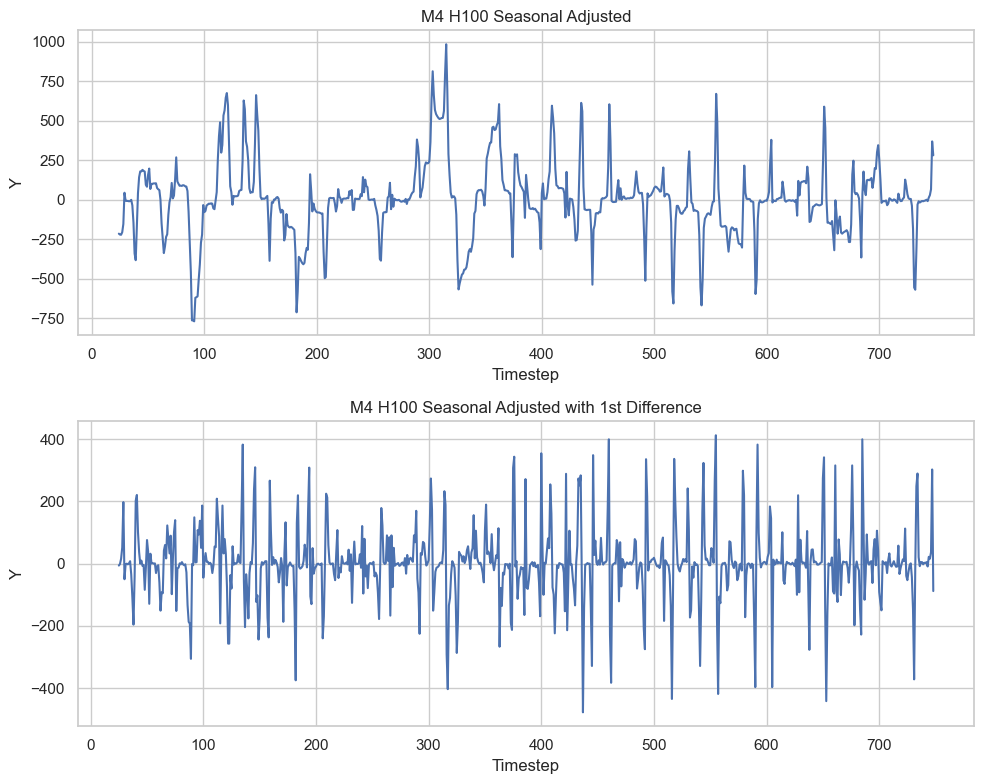

In [45]:
ds['y_season_diff'] = ds['y'].diff(periods=23)
ds['y_season_diff_1st_diff'] = ds['y_season_diff'].diff(1)

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

sns.lineplot(ax=axs[0], data=ds, x='ds', y='y_season_diff')
axs[0].set_title('M4 H100 Seasonal Adjusted')
axs[0].set_ylabel('Y')
axs[0].set_xlabel('Timestep')

sns.lineplot(ax=axs[1], data=ds, x='ds', y='y_season_diff_1st_diff')
axs[1].set_title('M4 H100 Seasonal Adjusted with 1st Difference')
axs[1].set_ylabel('Y')
axs[1].set_xlabel('Timestep')

plt.tight_layout()
plt.show()

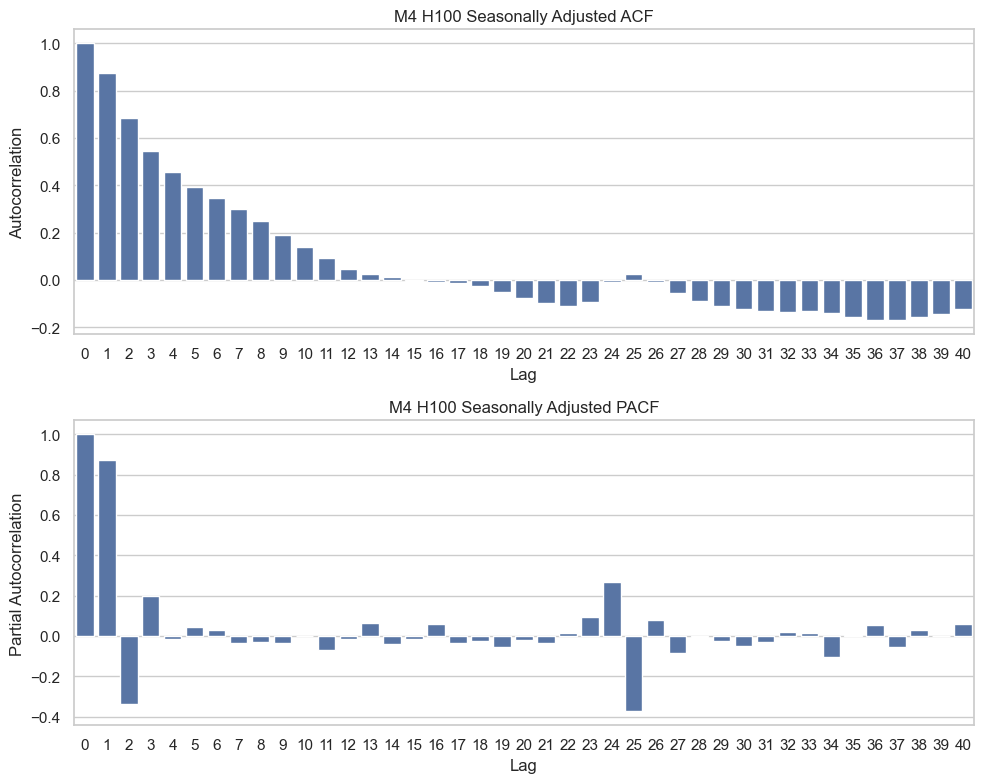

In [46]:
total_lags = 40

acf_values = acf(ds['y_season_diff'].dropna(), nlags=total_lags)
pacf_values = pacf(ds['y_season_diff'].dropna(), nlags=total_lags)

lags = np.arange(total_lags + 1)

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

sns.barplot(ax=axs[0], x=lags, y=acf_values)
axs[0].set_title('M4 H100 Seasonally Adjusted ACF')
axs[0].set_ylabel('Autocorrelation')
axs[0].set_xlabel('Lag')

sns.barplot(ax=axs[1], x=lags, y=pacf_values)
axs[1].set_title('M4 H100 Seasonally Adjusted PACF')
axs[1].set_ylabel('Partial Autocorrelation')
axs[1].set_xlabel('Lag')

plt.tight_layout()
plt.show()

### KPSS Test
---
Stands for *Kwiatkowsi-Phillips-Schimdt-Shin*, the economist who came up with the test. 

$$y_t = \xi t + \sum_{i=0}^tu_t + \epsilon_t$$

where
- $u_t$ is the random noise terms of distribution $(0, \sigma_u^2)$
- $\epsilon_t$ is the stationarity error
- $t$ is the timestep with scalar $\xi$

Onto the parts of the hypothesis testing.

> I think it's best to detrend ($\xi=0$) before doing this test. Their model assumes trend to be of a scaled linearly with a single parameter.

 - *Null hypothesis*: No random walk exists, $\sigma_u^2 = 0$.
 - *Test statistic*: 

$$LM = \frac{1}{{\hat{\sigma}_\epsilon^2}}\sum_{t=1}^T S_t^2$$

where $S_t$ is the rolling sum of the residuals.

$$S_t = \sum_{i=1}^t e_i$$

And $\hat{\sigma}_e^2$ is the standard error of the regression errors.

- *p-value*: From $\chi^2(T)$ distribution.

> Also, to understand why this comes out to a $\chi^2$ test, the sum of normal distributions is normal; then when you square and sum them, you get a $\chi^2$ distribution.

In [53]:
p_test = kpss(ds['y_season_diff_1st_diff'].dropna())

print(p_test)

C:\Users\Seraph\AppData\Local\Temp\ipykernel_17288\2368983171.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  p_test = kpss(ds['y_season_diff_1st_diff'].dropna())


(0.024351461995144024,
 0.1,
 27,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

### Autoregressive Model
---
We can make a model that depends on only the previous terms of an indexed time series; this is called an **Autoregressive model** AR($p$). On top of this, add a single white noise term $e_t$.

> 'auto' means self, therefore autoregressive meaning regressing on yourself (own values). 

$$y_t = c + \phi_1y_{t-1} + \phi_2 y_{y-2} + \cdots + \phi_p y_{t-p} + e_t$$

We can write it with a summand.

$$y_t = \sum_{i=1}^p \phi_i y_{t-i} + c +  e_t$$

And in backshift notation.

$$(1- \phi_1 B - \cdots - \phi_p B^p) y_t = c + e_t$$

#### Stationarity
Now we want to estimate the parameters of this model. We need to ensure stationarity on the AR model so that the autoregressive nature converges to a well-defined answer. 

> It's evident that a pure Linear Algebra approach won't work since your system will always be under-constrained.

First, let's find a way to rewrite the model to better study it. Notice you can write an AR($p$) model as a MA($\infty$) model. Starting with an AR($1$), expand on the autoregressive term $y_{t-1}$.

$$\begin{align}
y_t &= \phi_1 \textcolor{RedOrange}{y_{y-1}} + e_t \\
&= \phi_1 (\textcolor{RedOrange}{\phi_1 y_{t-2} + e_{t-1}}) + e_t \\
&= \phi^2y_{t-2} + \phi_1 e_{t-1} + e_t \\
&= \phi_1^3 y_{t-3} + \phi_1^2 e_{t-2} + \phi_1 e_{t-1} + e_t \\
&= \cdots \\
&= e_t + \sum_{i=1}^\infty \phi_1^i e_{t-i} \\
\end{align}$$

We want this series to converge. The only way that happens is when the parameter $\phi_1^i$ dies off eventually. What we want is for the limit of the sequence $\{\phi_1^i\}$ to converge to $0$. 

$$\lim_{i \rightarrow \infty} \phi_1^i = 0$$

That only happens when the sequence is a geometric series, therefore $\phi_1$ must lie in $(-1,1)$. For higher order AR models, the limiting behavior is the same, but the analysis becomes complicated.


In [54]:
ar1 = ARIMA(ds['y_season_diff_1st_diff'].reset_index(drop=True), order=(1,0,0))
results = ar1.fit()

ar1_resid = results.resid.fillna(0)

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:     y_season_diff_1st_diff   No. Observations:                  748
Model:                     ARIMA(1, 0, 0)   Log Likelihood               -4448.436
Date:                    Sun, 17 Mar 2024   AIC                           8902.873
Time:                            10:06:24   BIC                           8916.725
Sample:                                 0   HQIC                          8908.211
                                    - 748                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6851      5.585      0.123      0.902     -10.262      11.632
ar.L1          0.2467      0.024     10.488      0.000       0.201       0.293
sigma2      1.273e+04    408.543     31.166      0.000    1.19e+04    1.35e+04
===================================================================================
Ljung-Box (L1) (Q):                   3.57   Jarque-Bera (JB):               407.87
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               1.66   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
ar2 = ARIMA(ds['y_season_diff_1st_diff'].reset_index(drop=True), order=(2,0,0))
results = ar2.fit()

ar2_resid = results.resid.fillna(0)

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:     y_season_diff_1st_diff   No. Observations:                  748
Model:                     ARIMA(2, 0, 0)   Log Likelihood               -4418.981
Date:                    Sun, 17 Mar 2024   AIC                           8845.963
Time:                            10:05:58   BIC                           8864.432
Sample:                                 0   HQIC                          8853.080
                                    - 748                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6851      4.200      0.163      0.870      -7.547       8.917
ar.L1          0.3169      0.024     13.332      0.000       0.270       0.364
ar.L2         -0.2809      0.028     -9.947      0.000      -0.336      -0.226
sigma2      1.175e+04    418.221     28.098      0.000    1.09e+04    1.26e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):               269.61
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               1.46   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

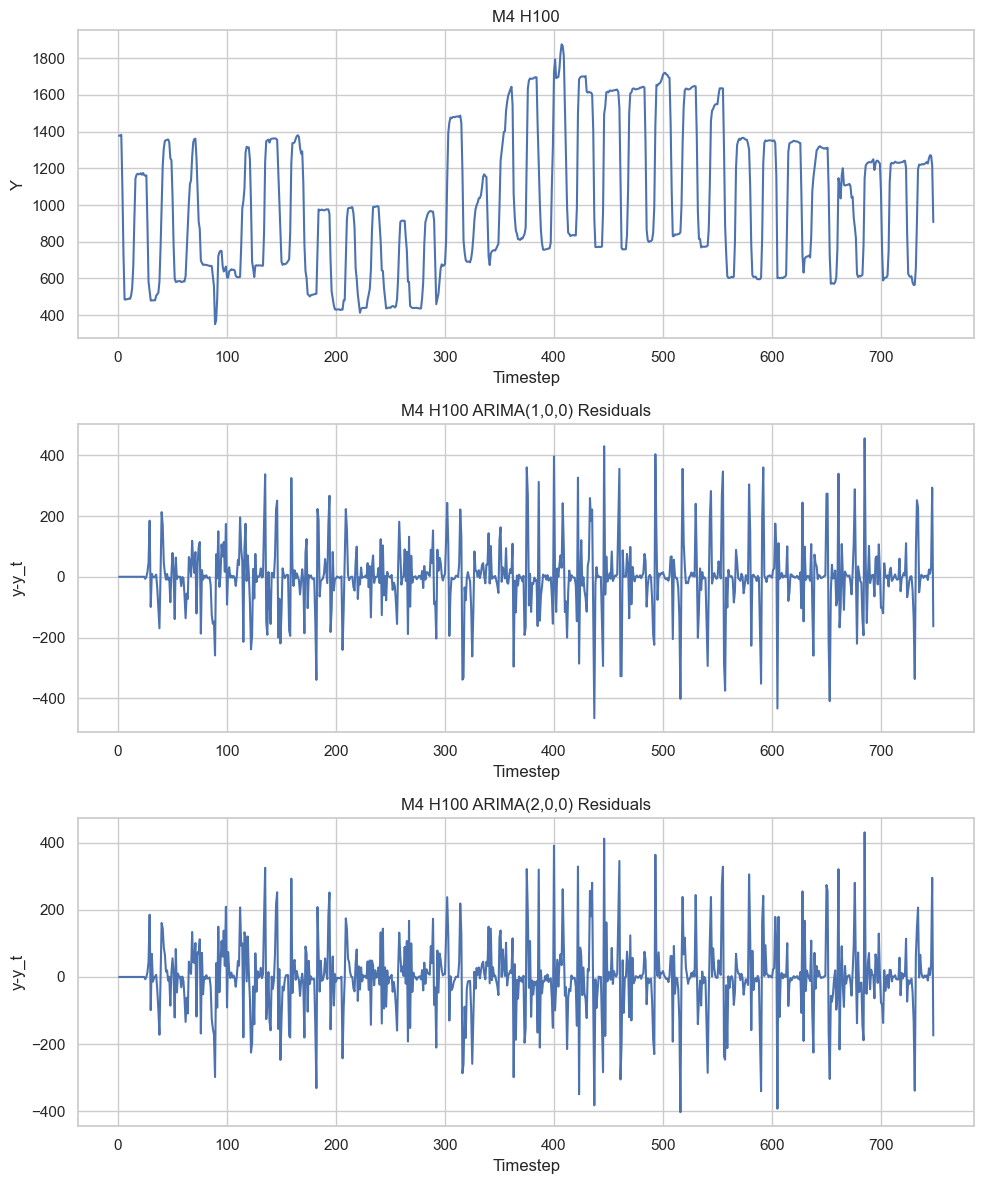

In [50]:
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

sns.lineplot(ax=axs[0], x=ds['ds'], y=ds['y'])
axs[0].set_title('M4 H100')
axs[0].set_ylabel('Y')
axs[0].set_xlabel('Timestep')

sns.lineplot(ax=axs[1], x=ds['ds'].reset_index(drop=True), y=ar1_resid)
axs[1].set_title('M4 H100 ARIMA(1,0,0) Residuals')
axs[1].set_ylabel('y-y_t')
axs[1].set_xlabel('Timestep')

sns.lineplot(ax=axs[2], x=ds['ds'].reset_index(drop=True), y=ar2_resid)
axs[2].set_title('M4 H100 ARIMA(2,0,0) Residuals')
axs[2].set_ylabel('y-y_t')
axs[2].set_xlabel('Timestep')

plt.tight_layout()
plt.show()

### Moving Average Model
---
Given the a stationary time series, we can try to model the *spikes* that occur. What we want is to model $y_t$ as a sum of error terms centered at $0$ and a spread we estimate based on the data. We call this a **Moving Average model** MA($q$).

> [!warning]
> Has nothing to do with moving average *smoothing* like in STL. The moving part comes from the fact that the "micro-variances" are changing throughout the time series.

$$y_t = c + e_t + \theta_1 e_{t-1}$$

With a summand.

$$y_t = c + e_t + \sum_{i=1}^q \theta_i e_{t-i}^i$$

Then in backshift notation.

$$y_t = c + (1 + \theta_1 B + \cdots + \theta_q B^q)e_t$$

#### Invertible
Like the analysis done on AR models, we can do the same with MA models. We can also go from a MA($q$) model into an AR($\infty$) model. Start with a basic MA($1$) process $y_t = \epsilon_t + \theta_1 \epsilon_{t-1}$.

$$\begin{align}
e_t &= y_t - \theta_1 \textcolor{RedOrange}{e_{t-1}} \\
&= y_t - \theta_1 (\textcolor{RedOrange}{y_{t-1} - \theta_1 e_{t-2}}) \\
&= y_t - \theta_1y_{t-1} - \theta_1^2e_{t-2}\\ 
&= \cdots \\
&= \sum_{i=0}^\infty (-\theta_1)^i y_{t-j} \\
\end{align}$$

Again, we can see that the limiting behavior of the sequence of parameters $\{(-\theta_1)^i\}$ shows that $\theta_1$ must lie in $(-1,1)$. Being capable of converting a MA model to an AR model is called **invertibility**. 

> [!question] When does invertibility matter?
> It makes MA models tractable. The infinite model proposition leads us to take action it's convergence, and there are specific conditions for convergence.

There is another view on invertibility based on the backshift notation. See that we have a polynomial operator $1 + \theta_1 B + \cdots + \theta_q B^q$ acting on the current error term $e_t$. That polynomial must not evaluate to $0$ for a meaningful model formulation; thus we study it's $0$s.

$$1 + \theta_1 B + \cdots + \theta_q B^q = 0$$

When we translate the constraints on $\theta_i$, the roots of this polynomial take a set of constraints as well. Leaving the analysis for another time, the roots of the polynomial must lie outside of the unit circle in $\mathbb C$.

In [51]:
ma1 = ARIMA(ds['y_season_diff'].reset_index(drop=True), order=(0,1,1))
results = ma1.fit()

ma1_resid = results.resid.fillna(0)

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          y_season_diff   No. Observations:                  748
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -4441.666
Date:                Sun, 17 Mar 2024   AIC                           8887.332
Time:                        10:05:59   BIC                           8896.564
Sample:                             0   HQIC                          8890.890
                                - 748                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3726      0.024     15.749      0.000       0.326       0.419
sigma2       1.22e+04    394.869     30.889      0.000    1.14e+04     1.3e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.10   Jarque-Bera (JB):               376.35
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               1.60   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
ma2 = ARIMA(ds['y_season_diff'].reset_index(drop=True), order=(0,1,2))
results = ma2.fit()

ma2_resid = results.resid.fillna(0)

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          y_season_diff   No. Observations:                  748
Model:                ARIMA(0, 1, 10)   Log Likelihood               -4404.372
Date:                Sun, 17 Mar 2024   AIC                           8830.743
Time:                        10:06:00   BIC                           8881.520
Sample:                             0   HQIC                          8850.312
                                - 748                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2350      1.985      0.118      0.906      -3.656       4.126
ma.L2         -0.2900      2.454     -0.118      0.906      -5.100       4.520
ma.L3         -0.2876      1.876     -0.153      0.878      -3.965       3.390
ma.L4         -0.1673      1.302     -0.129      0.898      -2.718       2.384
ma.L5         -0.1166      0.975     -0.120      0.905      -2.027       1.794
ma.L6         -0.0533      0.748     -0.071      0.943      -1.520       1.413
ma.L7         -0.0284      0.646     -0.044      0.965      -1.295       1.238
ma.L8         -0.0440      0.590     -0.075      0.940      -1.200       1.112
ma.L9         -0.1399      0.502     -0.279      0.781      -1.124       0.844
ma.L10        -0.1079      0.221     -0.489      0.625      -0.540       0.325
sigma2      1.094e+04   2.17e+04      0.504      0.615   -3.16e+04    5.35e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               254.22
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.42   Skew:                             0.18
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""